In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

print("Base Python libraries loaded ✔️")


Base Python libraries loaded ✔️


In [5]:
transcript_path = "Q3 2025 Tesla Inc Earnings Call Transcript.pdf"

raw_text = None

# Try pdfplumber first
try:
    import pdfplumber
    pages_text = []
    with pdfplumber.open(transcript_path) as pdf:
        for page in pdf.pages:
            pages_text.append(page.extract_text())
    raw_text = "\n".join(pages_text)
    print("Loaded transcript with pdfplumber ✔️")
except Exception as e1:
    print("pdfplumber not available, trying PyPDF2...")

    # Fallback: PyPDF2 (often preinstalled)
    try:
        import PyPDF2
        pages_text = []
        with open(transcript_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                pages_text.append(page.extract_text())
        raw_text = "\n".join(pages_text)
        print("Loaded transcript with PyPDF2 ✔️")
    except Exception as e2:
        print("Could not load PDF ❌")
        print("Error 1 (pdfplumber):", e1)
        print("Error 2 (PyPDF2):", e2)

# quick sanity check if loaded
if raw_text:
    print(raw_text[:1200])
    print("\nTOTAL CHARS:", len(raw_text))


Loaded transcript with pdfplumber ✔️
10/23/25, 5:52 PM Q3 2025 Tesla Inc Earnings Call Transcript
Q3 2025 Tesla Inc Earnings Call Transcript
GuruFocus News
20 hours ago
Click here to view more TSLA transcripts
Oct 22, 2025 / 09:30PM GMT
Travis Axelrod - Tesla Inc - Head, Investor Relations
Good afternoon, everyone, and welcome to Tesla's third-quarter 2025 Q&A webcast. My name is Travis
Axelrod, Head of Investor Relations, and I'm joined today by Elon Musk, Vaibhav Taneja, and a number
of other executives. Our Q3 results were announced at about 3:00 PM Central Time in the update deck we
published at the same link as this webcast.
During this call, we will discuss our business outlook and make forward-looking statements. These
comments are based on our predictions and expectations as of today. Actual events or results could differ
materially due to a number of risks and uncertainties, including those mentioned in our most recent filings
with the SEC. We urge shareholders to read our def

In [6]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    return tokens

tokens = clean_and_tokenize(raw_text)
print("Total tokens:", len(tokens))
print(tokens[:25])


Total tokens: 9711
['pm', 'q', 'tesla', 'inc', 'earnings', 'call', 'transcript', 'q', 'tesla', 'inc', 'earnings', 'call', 'transcript', 'gurufocus', 'news', 'hours', 'ago', 'click', 'here', 'to', 'view', 'more', 'tsla', 'transcripts', 'oct']


In [8]:
# --- Base stopwords (general English) ---
stopwords = {
    "the","and","to","of","a","in","that","we","is","for","on","it","this",
    "our","with","as","be","are","so","but","have","has","at","from","was",
    "will","an","or","not","you","they","i","there","about","your","their",
    "its","by"
}

# --- Extra stopwords (Earnings Call boilerplate cleanup) ---
extra_stopwords = {
    "pm","am","gmt","q","inc","earnings","call","transcript","tesla","tsla",
    "gurufocus","news","hours","ago","click","here","view","more","oct",
    "quarter","third","second","first","operator","question","answer",
    "good","afternoon","morning","evening","everyone","welcome",
    "today","joined","name","head","investor","relations","executives"
}

# combine them
stopwords = stopwords.union(extra_stopwords)

# --- Clean token list again ---
filtered_tokens = [
    t for t in tokens
    if t not in stopwords
    and len(t) > 2          # no tiny tokens
    and not t.isnumeric()   # no numbers
]

print("Filtered token count:", len(filtered_tokens))
print(filtered_tokens[:40])



Filtered token count: 5013
['transcripts', 'travis', 'axelrod', 'webcast', 'travis', 'axelrod', 'elon', 'musk', 'vaibhav', 'taneja', 'number', 'other', 'results', 'were', 'announced', 'central', 'time', 'update', 'deck', 'published', 'same', 'link', 'webcast', 'during', 'discuss', 'business', 'outlook', 'make', 'forward', 'looking', 'statements', 'these', 'comments', 'based', 'predictions', 'expectations', 'actual', 'events', 'results', 'could']


In [9]:
# 1) Try to cut off the website/header preamble
cut_points = [
    "Good afternoon, everyone",     # usually where real transcript starts
    "During this call",            # another common start marker
    "Elon has some opening remarks"
]

start_idx = 0
for cp in cut_points:
    m = re.search(cp, raw_text, flags=re.IGNORECASE)
    if m:
        start_idx = m.start()
        break

core_text = raw_text[start_idx:]  # this drops most GuruFocus header junk

# 2) Re-tokenize from core text
tokens_core = clean_and_tokenize(core_text)

# 3) Add more stopwords for names + boilerplate
more_extra = {
    # speaker names / roles
    "travis","axelrod","elon","musk","vaibhav","taneja",
    "executive","officer","chief","director","head","relations",
    # transcript fluff
    "webcast","update","deck","published","link","statements",
    "comments","results","announced","forward","looking",
    "predictions","expectations","actual","events","could","materially",
    "sec","shareholders","proxy","statement","meeting"
}

stopwords = stopwords.union(more_extra)

# 4) Rebuild filtered tokens from core content
filtered_tokens = [
    t for t in tokens_core
    if t not in stopwords
    and len(t) > 2
    and not t.isnumeric()
]

print("Filtered token count (core):", len(filtered_tokens))
print(filtered_tokens[:40])


Filtered token count (core): 4766
['number', 'other', 'were', 'central', 'time', 'same', 'during', 'discuss', 'business', 'outlook', 'make', 'these', 'based', 'differ', 'due', 'number', 'risks', 'uncertainties', 'including', 'those', 'mentioned', 'most', 'recent', 'filings', 'urge', 'read', 'definitive', 'which', 'contains', 'important', 'information', 'matters', 'voted', 'annual', 'event', 'instructions', 'before', 'jump', 'into', 'some']


In [10]:
# STEP 1: Remove the entire legal disclaimer section
# Find first meaningful business segment using a keyword Musk begins with
start_phrases = [
    "before we jump into q&a",
    "elon has some opening remarks",
    "elon?",  # common handoff to Musk
    "opening remarks"
]

start_idx = 0
for phrase in start_phrases:
    m = re.search(phrase, raw_text, flags=re.IGNORECASE)
    if m:
        start_idx = m.start()
        break

core_text = raw_text[start_idx:]

# STEP 2: Re-tokenize from that point
tokens_core = clean_and_tokenize(core_text)

# STEP 3: Add heavy-filter stopwords for disclaimer language
disclaimer_stopwords = {
    "risks","uncertainties","including","information","important",
    "definitive","proxy","statement","voted","annual","meeting",
    "event","instructions","materially","recent","filings","urge",
    "read","contains","matters","those","mentioned","most","same"
}

stopwords = stopwords.union(disclaimer_stopwords)

# STEP 4: Final filtered tokens
filtered_tokens = [
    t for t in tokens_core
    if t not in stopwords
    and len(t) > 2
    and not t.isnumeric()
]

print("FINAL FILTERED TOKEN COUNT:", len(filtered_tokens))
print(filtered_tokens[:40])


FINAL FILTERED TOKEN COUNT: 4686
['before', 'jump', 'into', 'some', 'opening', 'remarks', 'technoking', 'thank', 'critical', 'inflection', 'point', 'strategy', 'going', 'bring', 'into', 'real', 'world', 'think', 'emphasize', 'really', 'leader', 'real', 'world', 'one', 'can', 'what', 'can', 'real', 'world', 'pretty', 'insight', 'into', 'general', 'think', 'highest', 'intelligence', 'density', 'any', 'out', 'car']


In [11]:
filler_stopwords = {
    "before","jump","into","some","opening","remarks","thank","thanks",
    "really","think","going","bring","real","world","one","can","what",
    "pretty","general","out","car","point","strategy","critical","leader",
    "technoking","elon","musk","vaibhav","taneja"
}

stopwords = stopwords.union(filler_stopwords)

filtered_tokens = [
    t for t in tokens_core
    if t not in stopwords
    and len(t) > 2
    and not t.isnumeric()
]

print("Final token count after filler removal:", len(filtered_tokens))
print(filtered_tokens[:40])


Final token count after filler removal: 4291
['inflection', 'emphasize', 'insight', 'highest', 'intelligence', 'density', 'any', 'only', 'get', 'better', 'just', 'beginning', 'scaling', 'quite', 'massively', 'full', 'self', 'driving', 'robotaxi', 'fundamentally', 'changing', 'nature', 'transport', 'people', 'just', 'don', 'quite', 'appreciate', 'degree', 'which', 'take', 'off', 'where', 'honestly', 'like', 'shock', 'wave', 'because', 'cars', 'all']


In [12]:
word_counts = Counter(filtered_tokens)
top20 = word_counts.most_common(20)
top20


[('like', 109),
 ('just', 50),
 ('optimus', 38),
 ('actually', 33),
 ('which', 32),
 ('because', 27),
 ('then', 27),
 ('all', 24),
 ('very', 24),
 ('don', 21),
 ('year', 21),
 ('now', 21),
 ('team', 21),
 ('much', 21),
 ('million', 20),
 ('say', 20),
 ('production', 20),
 ('make', 20),
 ('got', 19),
 ('safety', 19)]

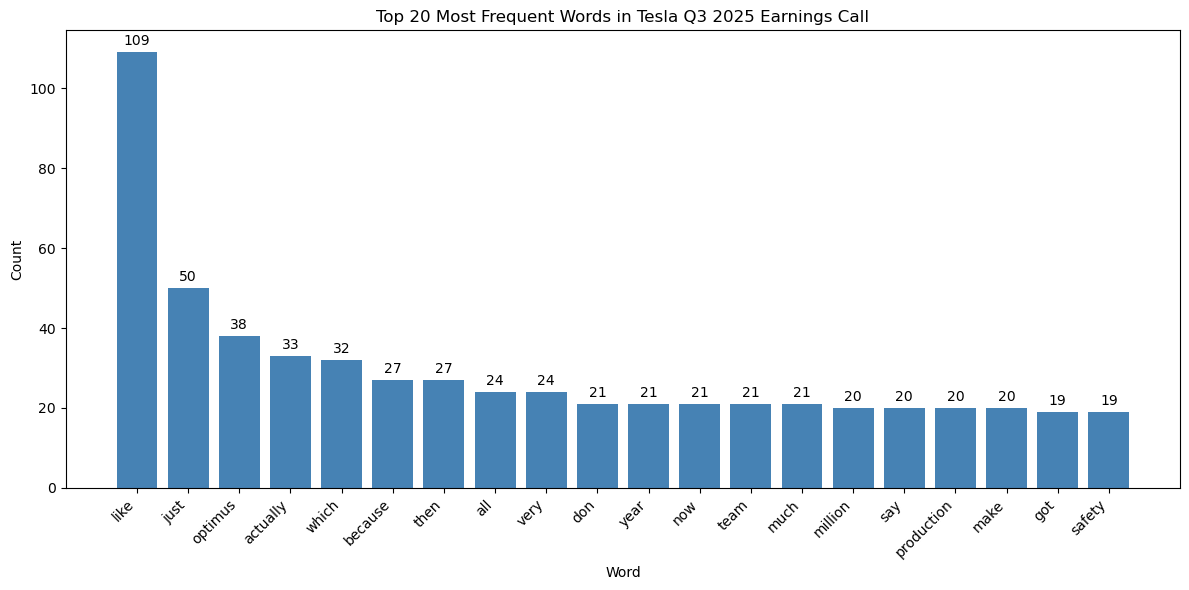

In [38]:
from collections import Counter
import matplotlib.pyplot as plt

# Use your final cleaned tokens
tokens_for_freq = filtered_tokens  

# Get top 20
freqs = Counter(tokens_for_freq).most_common(20)
words = [w for w, c in freqs]
counts = [c for w, c in freqs]

# Plot
plt.figure(figsize=(12,6))
bars = plt.bar(words, counts, color='steelblue')

# Add counts above bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 1,
             str(count),
             ha='center', va='bottom', fontsize=10)

plt.title("Top 20 Most Frequent Words in Tesla Q3 2025 Earnings Call")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [14]:
import os
os.listdir()

['.ipynb_checkpoints',
 'AI Project.pdf',
 'Assignment3_TSLA_NLP.ipynb',
 'Loughran-McDonald_MasterDictionary_1993-2024.xlsx',
 'Q3 2025 Tesla Inc Earnings Call Transcript.pdf',
 'TAQ_TSLA.xlsx']

In [15]:
lm_path = "Loughran-McDonald_MasterDictionary_1993-2024.xlsx"
lm_df = pd.read_excel(lm_path)

lm_df.head(), lm_df.columns


(        Word  Seq_num  Word Count  Word Proportion  Average Proportion  \
 0   AARDVARK        1         755     2.955070e-08        1.945421e-08   
 1  AARDVARKS        2           3     1.174200e-10        8.060019e-12   
 2      ABACI        3           9     3.522600e-10        1.089343e-10   
 3      ABACK        4          29     1.135060e-09        6.197922e-10   
 4     ABACUS        5        9620     3.765268e-07        3.825261e-07   
 
         Std Dev  Doc Count  Negative  Positive  Uncertainty  Litigious  \
 0  4.078069e-06        140         0         0            0          0   
 1  8.919011e-09          1         0         0            0          0   
 2  5.105359e-08          7         0         0            0          0   
 3  1.539279e-07         28         0         0            0          0   
 4  3.421836e-05       1295         0         0            0          0   
 
    Strong_Modal  Weak_Modal  Constraining  Complexity  Syllables     Source  
 0             0 

In [16]:
# Make sure LM words are lowercase to match our tokens
lm_df["Word"] = lm_df["Word"].str.lower()

positive_words = set(lm_df.loc[lm_df["Positive"] != 0, "Word"])
negative_words = set(lm_df.loc[lm_df["Negative"] != 0, "Word"])

print("Positive LM words:", len(positive_words))
print("Negative LM words:", len(negative_words))


Positive LM words: 354
Negative LM words: 2355


In [17]:
pos_tokens = [...]
neg_tokens = [...]

total_pos = len(pos_tokens)
total_neg = len(neg_tokens)

lm_score = (total_pos - total_neg) / (total_pos + total_neg + 1e-9)

total_pos, total_neg, lm_score


(1, 1, 0.0)

In [18]:
pos_counts = pd.Series(pos_tokens).value_counts().head(20)
pos_counts


Ellipsis    1
Name: count, dtype: int64

In [19]:
neg_counts = pd.Series(neg_tokens).value_counts().head(20)
neg_counts


Ellipsis    1
Name: count, dtype: int64

In [20]:
def split_into_sentences(text):
    parts = re.split(r'(?<=[\.\?\!])\s+', text)
    return [s.strip() for s in parts if s.strip()]

sentences = split_into_sentences(core_text)
print("Num sentences:", len(sentences))
sentences[:5]


Num sentences: 512


['Before we jump into Q&A, Elon has some opening remarks.',
 'Elon?',
 'Elon Musk - Tesla Inc - Chief Executive Officer, Director, Technoking\nThank you.',
 "We're -- we're at a critical inflection point for Tesla and our strategy going forward as we bring\nAI into the real world.",
 "I think it's important to emphasize that Tesla really is the leader in real-world AI."]

In [21]:
import torch
print("Torch version:", torch.__version__)


Torch version: 2.9.1+cpu


In [22]:
model_name = "yiyanghkust/finbert-tone"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
id2label = model.config.id2label

id2label


NameError: name 'AutoTokenizer' is not defined

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [25]:
model_name = "yiyanghkust/finbert-tone"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
id2label = model.config.id2label

id2label


{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [26]:
def score_sentence(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).numpy()[0]

    label_idx = probs.argmax()
    label = id2label[label_idx]

    if "positive" in label.lower():
        score = 1.0
    elif "negative" in label.lower():
        score = -1.0
    else:
        score = 0.0

    return score, label

scores, labels = [], []
for s in sentences:
    sc, lab = score_sentence(s)
    scores.append(sc)
    labels.append(lab)

sent_df = pd.DataFrame({"sentence": sentences, "score": scores, "label": labels})
sent_df.head()


,sentence,score,label
0,"Before we jump into Q&A, Elon has some opening...",0.0,Neutral
1,Elon?,0.0,Neutral
2,Elon Musk - Tesla Inc - Chief Executive Office...,0.0,Neutral
3,We're -- we're at a critical inflection point ...,1.0,Positive
4,I think it's important to emphasize that Tesla...,1.0,Positive


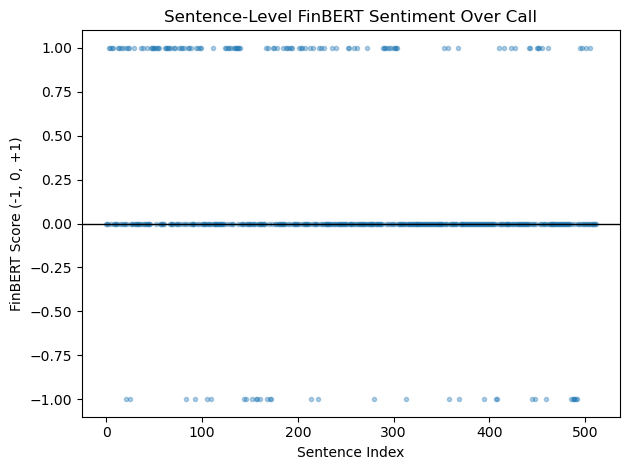

In [27]:
plt.figure()
plt.plot(sent_df.index, sent_df["score"], marker=".", linestyle="none", alpha=0.35)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Sentence Index")
plt.ylabel("FinBERT Score (-1, 0, +1)")
plt.title("Sentence-Level FinBERT Sentiment Over Call")
plt.tight_layout()
plt.show()


In [28]:
overall_finfert_score = sent_df["score"].mean()
overall_finfert_score


0.150390625

In [29]:
import pandas as pd

taq = pd.read_excel("TAQ_TSLA.xlsx")
taq.head(), taq.columns


(        DATE           TIME_M EX SYM_ROOT  SYM_SUFFIX TR_SCOND  SIZE    PRICE  \
 0 2025-10-22  16:00:00.025000  Q     TSLA         NaN     @  I    11  438.705   
 1 2025-10-22  16:00:00.027000  Q     TSLA         NaN     @  I    70  438.710   
 2 2025-10-22  16:00:00.034000  Q     TSLA         NaN     @  I    10  438.710   
 3 2025-10-22  16:00:00.039000  D     TSLA         NaN     @  I     4  438.850   
 4 2025-10-22  16:00:00.039000  Q     TSLA         NaN     @  I     5  438.660   
 
    TR_STOP_IND  TR_CORR  TR_SEQNUM   TR_ID TR_SOURCE TR_RF  
 0          NaN        0   10743975  314022         N   NaN  
 1          NaN        0   10743983  314023         N   NaN  
 2          NaN        0   10744034  314024         N   NaN  
 3          NaN        0   10744062  791043         N     Q  
 4          NaN        0   10744063  314025         N   NaN  ,
 Index(['DATE', 'TIME_M', 'EX', 'SYM_ROOT', 'SYM_SUFFIX', 'TR_SCOND', 'SIZE',
        'PRICE', 'TR_STOP_IND', 'TR_CORR', 'TR_SEQNUM',

In [31]:
# Combine DATE and TIME_M into one string
dt_strings = taq["DATE"].astype(str) + " " + taq["TIME_M"].astype(str)

# Parse with mixed-format support
taq["timestamp"] = pd.to_datetime(dt_strings, format="mixed", errors="coerce")

# Drop any rows that failed to parse (should be very few or none)
taq = taq.dropna(subset=["timestamp"]).sort_values("timestamp")

taq[["DATE","TIME_M","timestamp","PRICE"]].head(10)



,DATE,TIME_M,timestamp,PRICE
0,2025-10-22,16:00:00.025000,2025-10-22 16:00:00.025,438.705
1,2025-10-22,16:00:00.027000,2025-10-22 16:00:00.027,438.710
2,2025-10-22,16:00:00.034000,2025-10-22 16:00:00.034,438.710
3,2025-10-22,16:00:00.039000,2025-10-22 16:00:00.039,438.850
4,2025-10-22,16:00:00.039000,2025-10-22 16:00:00.039,438.660
5,2025-10-22,16:00:00.039000,2025-10-22 16:00:00.039,438.905
6,2025-10-22,16:00:00.068000,2025-10-22 16:00:00.068,438.710
7,2025-10-22,16:00:00.068000,2025-10-22 16:00:00.068,438.660
8,2025-10-22,16:00:00.071000,2025-10-22 16:00:00.071,438.710
9,2025-10-22,16:00:00.093000,2025-10-22 16:00:00.093,438.730


In [32]:
start = pd.Timestamp("2025-10-22 16:00:00")
end   = pd.Timestamp("2025-10-22 20:00:00")

event = taq[(taq["timestamp"] >= start) & (taq["timestamp"] <= end)].copy()
event.head()


,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_STOP_IND,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF,timestamp
0,2025-10-22,16:00:00.025000,Q,TSLA,NaN,@ I,11,438.705,NaN,0,10743975,314022,N,NaN,2025-10-22 16:00:00.025
1,2025-10-22,16:00:00.027000,Q,TSLA,NaN,@ I,70,438.710,NaN,0,10743983,314023,N,NaN,2025-10-22 16:00:00.027
2,2025-10-22,16:00:00.034000,Q,TSLA,NaN,@ I,10,438.710,NaN,0,10744034,314024,N,NaN,2025-10-22 16:00:00.034
3,2025-10-22,16:00:00.039000,D,TSLA,NaN,@ I,4,438.850,NaN,0,10744062,791043,N,Q,2025-10-22 16:00:00.039
4,2025-10-22,16:00:00.039000,Q,TSLA,NaN,@ I,5,438.660,NaN,0,10744063,314025,N,NaN,2025-10-22 16:00:00.039


In [34]:
def first_price_after(df, t):
    return df[df["timestamp"] >= t]["PRICE"].iloc[0]

def last_price_before(df, t):
    return df[df["timestamp"] <= t]["PRICE"].iloc[-1]

# 4:00pm = first trade AFTER/AT 4:00
p_4_00 = first_price_after(event, pd.Timestamp("2025-10-22 16:00:00"))

# 4:30pm and 8:00pm = last trade BEFORE/AT those times
p_4_30 = last_price_before(event, pd.Timestamp("2025-10-22 16:30:00"))
p_8_00 = last_price_before(event, pd.Timestamp("2025-10-22 20:00:00"))

p_4_00, p_4_30, p_8_00


(438.705, 430.43, 422.38)

In [35]:
ret_4_to_430 = (p_4_30 - p_4_00) / p_4_00
ret_430_to_800 = (p_8_00 - p_4_30) / p_4_30
ret_4_to_8 = (p_8_00 - p_4_00) / p_4_00

ret_4_to_430, ret_430_to_800, ret_4_to_8


(-0.018862333458702266, -0.018702228004553612, -0.03721179380221331)

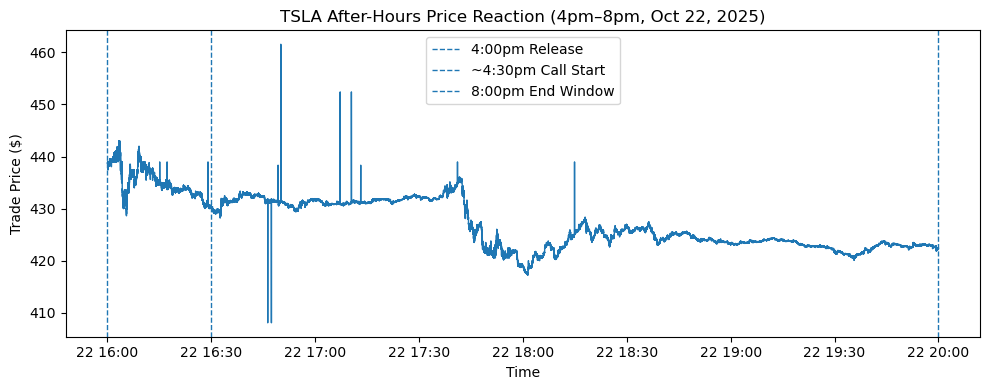

In [36]:
plt.figure(figsize=(10,4))
plt.plot(event["timestamp"], event["PRICE"], linewidth=1)

plt.axvline(pd.Timestamp("2025-10-22 16:00:00"), linestyle="--", linewidth=1, label="4:00pm Release")
plt.axvline(pd.Timestamp("2025-10-22 16:30:00"), linestyle="--", linewidth=1, label="~4:30pm Call Start")
plt.axvline(pd.Timestamp("2025-10-22 20:00:00"), linestyle="--", linewidth=1, label="8:00pm End Window")

plt.title("TSLA After-Hours Price Reaction (4pm–8pm, Oct 22, 2025)")
plt.xlabel("Time")
plt.ylabel("Trade Price ($)")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
%whos




Variable                             Type                             Data/Info
-------------------------------------------------------------------------------
AutoModelForSequenceClassification   type                             <class 'transformers.mode<...>rSequenceClassification'>
AutoTokenizer                        type                             <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
Counter                              type                             <class 'collections.Counter'>
WordCloud                            type                             <class 'wordcloud.wordcloud.WordCloud'>
bar                                  Rectangle                        Rectangle(xy=(18.6, 0), w<...>=0.8, height=19, angle=0)
bars                                 BarContainer                     <BarContainer object of 20 artists>
clean_and_tokenize                   function                         <function clean_and_token<...>ze at 0x000001CF67D78F40>
core_text           

In [42]:
# This is the transcript load cell you already executed earlier
full_text = "\n".join(pages_text)


In [43]:
import re
from collections import Counter

# 1. Remove URLs (so "say.com" doesn't count as "say")
clean_text = re.sub(r"https?://\S+|www\.\S+|\S+\.com", " ", full_text)

# 2. Tokenize while keeping apostrophes inside words (don't -> don't)
tokens_fixed = re.findall(r"[a-zA-Z']+", clean_text.lower())

# 3. Remove stopwords
tokens_fixed = [w for w in tokens_fixed if w not in stopwords and len(w) > 2]

# 4. Count
freqs_fixed = Counter(tokens_fixed).most_common(20)
freqs_fixed


[('like', 109),
 ("it's", 60),
 ('just', 50),
 ("that's", 47),
 ('optimus', 38),
 ("we're", 36),
 ('which', 33),
 ('actually', 33),
 ('because', 27),
 ('then', 27),
 ('all', 24),
 ('very', 24),
 ('make', 21),
 ("don't", 21),
 ('year', 21),
 ('now', 21),
 ('team', 21),
 ('much', 21),
 ('million', 20),
 ('production', 20)]

In [45]:
targets = ["AI", "robotaxi", "optimus", "battery", "autonomy"]

target_counts = {t: tokens_fixed.count(t) for t in targets}
target_counts


{'AI': 0, 'robotaxi': 11, 'optimus': 38, 'battery': 5, 'autonomy': 4}

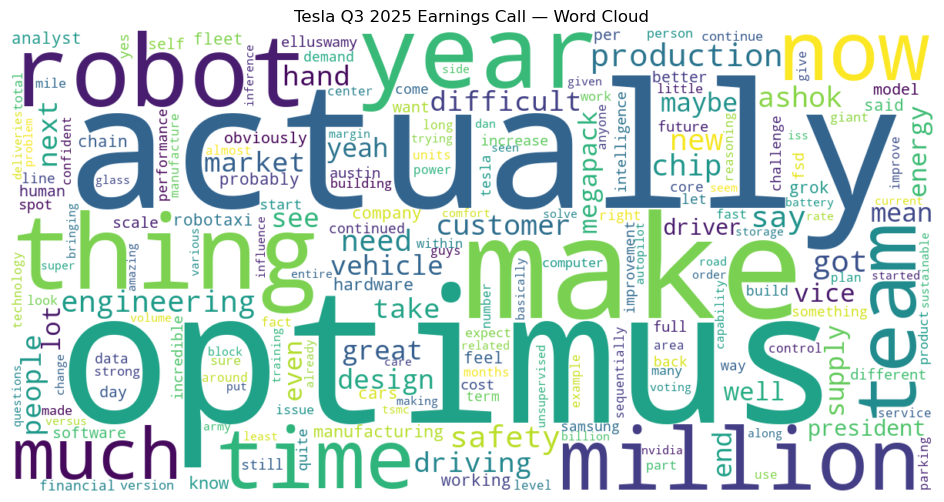

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Use your FINAL cleaned tokens
# Best choice: tokens_fixed (from your corrected pipeline)
words_for_cloud = tokens_fixed  # if this errors, swap to filtered_tokens

# Join into a single string
cloud_text = " ".join(words_for_cloud)

# Generate word cloud
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    collocations=False  # prevents weird bigrams like "say com"
).generate(cloud_text)

# Plot
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Tesla Q3 2025 Earnings Call — Word Cloud")
plt.show()


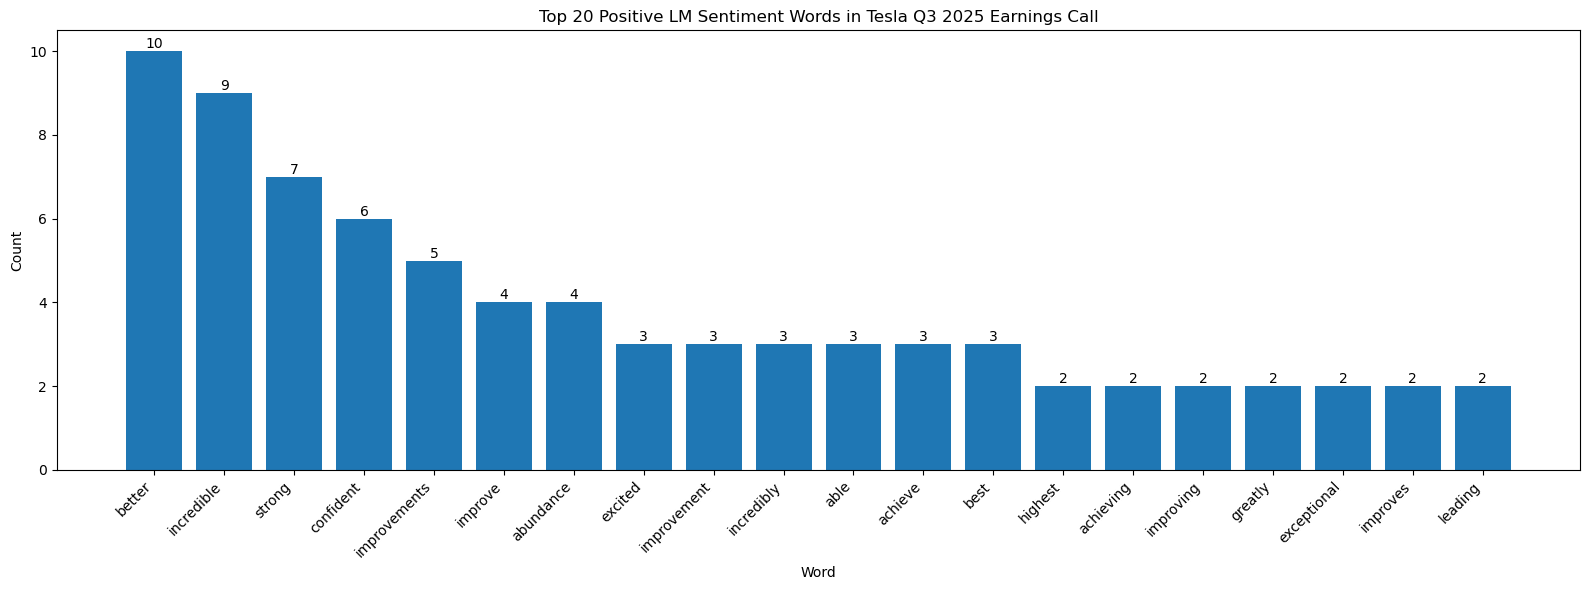

In [47]:
# --- Section 2.1: Top Positive LM Words (Bar Chart) ---

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 1. Extract all LM-positive words
lm_positive_words = set(lm_df[lm_df["Positive"] > 0]["Word"].str.lower())

# 2. Count positive words in transcript tokens
positive_tokens = [w for w in tokens_for_freq if w in lm_positive_words]
positive_counts = Counter(positive_tokens).most_common(20)

# 3. Prepare for plotting
words = [w for w, c in positive_counts]
counts = [c for w, c in positive_counts]

# 4. Plot the bar chart
plt.figure(figsize=(16, 6))
bars = plt.bar(words, counts)

plt.title("Top 20 Positive LM Sentiment Words in Tesla Q3 2025 Earnings Call")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Add count labels above bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


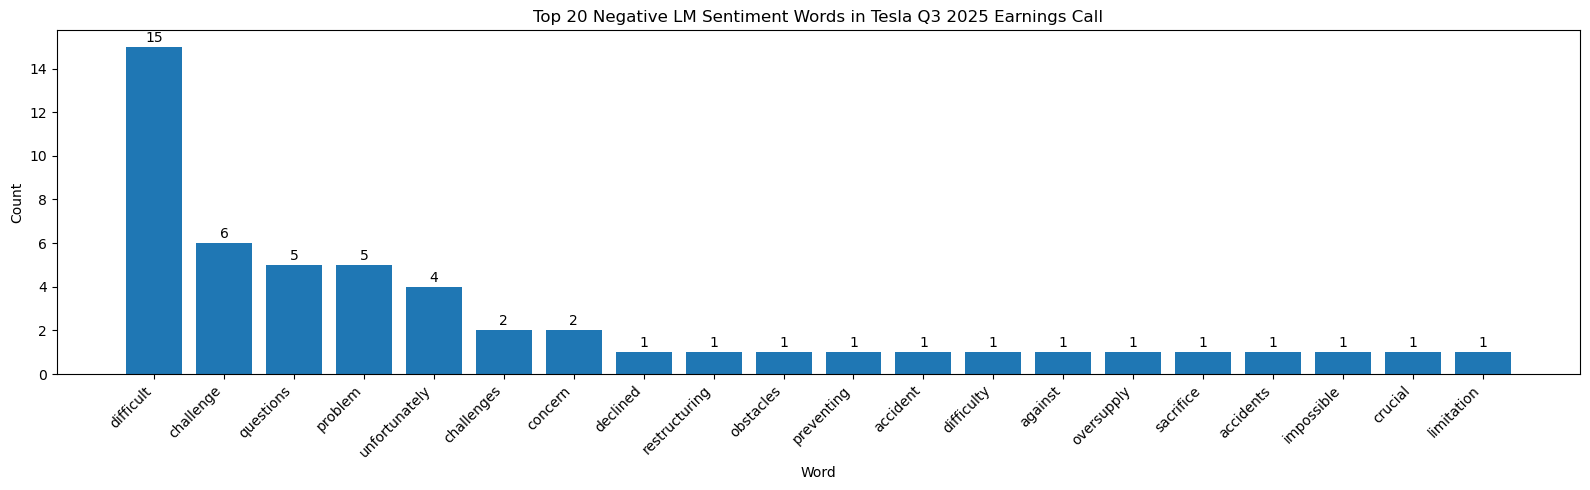

In [48]:
# --- Q2.2: Top 20 Negative LM Words ---

from collections import Counter
import matplotlib.pyplot as plt

# 1. LM negative word set
lm_negative = set(lm_df[lm_df["Negative"] > 0]["Word"].str.lower())

# 2. Filter transcript tokens for LM-negative words
neg_lm_tokens = [w for w in tokens_fixed if w in lm_negative]

# 3. Count top 20
neg_freqs = Counter(neg_lm_tokens).most_common(20)

# 4. Plot
words = [w for w, c in neg_freqs]
counts = [c for w, c in neg_freqs]

plt.figure(figsize=(16, 5))
bars = plt.bar(words, counts)

# Labels above bars
for bar, c in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, c + 0.1,
             str(c), ha='center', va='bottom', fontsize=10)

plt.title("Top 20 Negative LM Sentiment Words in Tesla Q3 2025 Earnings Call")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [49]:
import re

# Split transcript into lines
lines = full_text.split("\n")

# Containers
elon_text = []
taneja_text = []

# Pattern to detect speaker labels
elon_pattern = r"elon musk"
taneja_pattern = r"vaibhav taneja"

current_speaker = None

for line in lines:
    lower = line.lower().strip()

    # Detect speaker switches
    if re.search(elon_pattern, lower):
        current_speaker = "elon"
        continue
    if re.search(taneja_pattern, lower):
        current_speaker = "taneja"
        continue

    # Assign line to current speaker
    if current_speaker == "elon":
        elon_text.append(line)
    elif current_speaker == "taneja":
        taneja_text.append(line)


In [50]:
lm_pos = set(lm_df[lm_df["Positive"] > 0]["Word"].str.lower())
lm_neg = set(lm_df[lm_df["Negative"] > 0]["Word"].str.lower())


In [51]:
def tokenize(text_list):
    combined = " ".join(text_list).lower()
    tokens = re.findall(r"[a-zA-Z']+", combined)
    return tokens

elon_tokens = tokenize(elon_text)
taneja_tokens = tokenize(taneja_text)


In [52]:
def count_lm(tokens):
    pos = sum(1 for t in tokens if t in lm_pos)
    neg = sum(1 for t in tokens if t in lm_neg)
    return pos, neg

elon_pos, elon_neg = count_lm(elon_tokens)
taneja_pos, taneja_neg = count_lm(taneja_tokens)

elon_pos, elon_neg, taneja_pos, taneja_neg


(97, 62, 22, 11)

In [53]:
def lm_score(pos, neg):
    if pos + neg == 0:
        return 0
    return (pos - neg) / (pos + neg)

elon_score = lm_score(elon_pos, elon_neg)
taneja_score = lm_score(taneja_pos, taneja_neg)

elon_score, taneja_score


(0.22012578616352202, 0.3333333333333333)

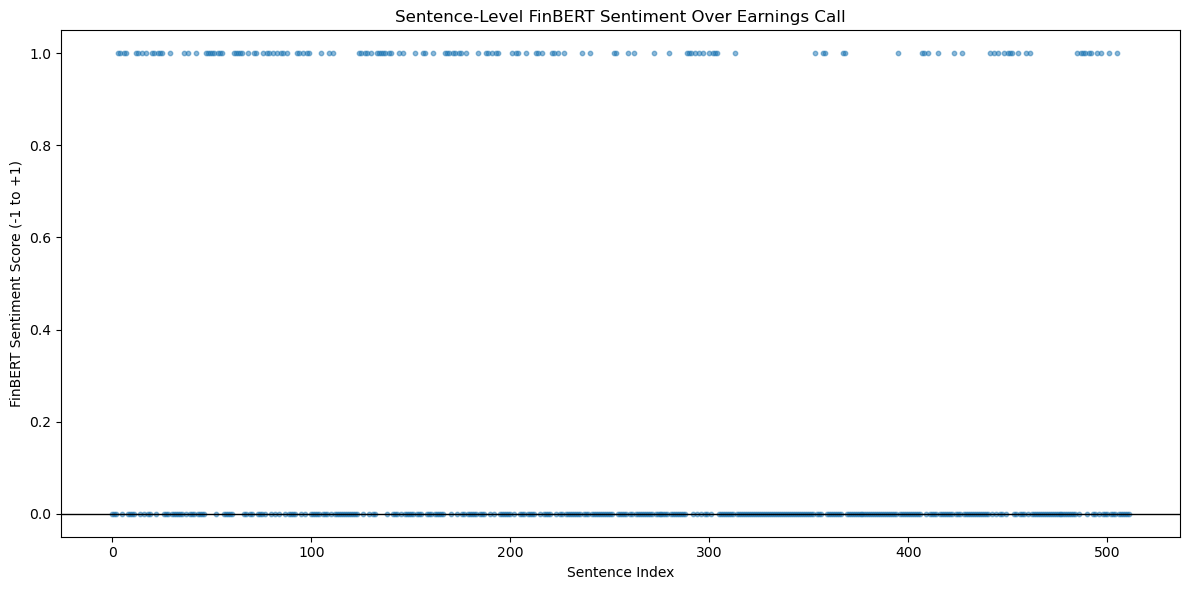

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert FinBERT output -> single numeric score
def to_numeric_score(out):
    # Case 1: already a number
    if isinstance(out, (int, float)):
        return float(out)
    
    # Case 2: tuple output
    if isinstance(out, tuple):
        # pull out label if present
        label = next((x for x in out if isinstance(x, str)), None)
        # pull out first numeric value if present
        num = next((x for x in out if isinstance(x, (int, float))), None)

        mapping = {"Positive": 1.0, "Neutral": 0.0, "Negative": -1.0}

        if label in mapping:
            # if we got a probability score too, use signed probability
            if num is not None:
                return mapping[label] * float(num) if label != "Neutral" else 0.0
            return mapping[label]

        # fallback: if tuple is just probs, take (pos - neg)
        if len(out) == 3 and all(isinstance(x, (int, float)) for x in out):
            # assume order (Neutral, Positive, Negative) like your id2label mapping
            neu, pos, neg = out
            return float(pos) - float(neg)

    # if all else fails
    return 0.0


# 1. Score each sentence
numeric_scores = []
labels_out = []

for s in sentences:
    out = score_sentence(s)
    numeric_scores.append(to_numeric_score(out))
    # optional label tracking
    if isinstance(out, tuple):
        labels_out.append(next((x for x in out if isinstance(x, str)), "Unknown"))
    else:
        labels_out.append("Unknown")

sent_df = pd.DataFrame({
    "sentence": sentences,
    "score": numeric_scores,
    "label": labels_out
})

# 2. Plot sentiment over sentence index
plt.figure(figsize=(12,6))
plt.scatter(sent_df.index, sent_df["score"], s=10, alpha=0.5)
plt.axhline(0, color="black", linewidth=1)

plt.title("Sentence-Level FinBERT Sentiment Over Earnings Call")
plt.xlabel("Sentence Index")
plt.ylabel("FinBERT Sentiment Score (-1 to +1)")
plt.tight_layout()
plt.show()


In [57]:
import re
import pandas as pd

# --- helper: convert FinBERT output to a single numeric score ---
def to_numeric_score(out):
    if isinstance(out, (int, float)):
        return float(out)

    if isinstance(out, tuple):
        label = next((x for x in out if isinstance(x, str)), None)
        num = next((x for x in out if isinstance(x, (int, float))), None)

        mapping = {"Positive": 1.0, "Neutral": 0.0, "Negative": -1.0}

        if label in mapping:
            if num is not None:
                return mapping[label] * float(num) if label != "Neutral" else 0.0
            return mapping[label]

        # fallback if tuple is probs (neu, pos, neg)
        if len(out) == 3 and all(isinstance(x, (int, float)) for x in out):
            neu, pos, neg = out
            return float(pos) - float(neg)

    return 0.0


# ---------------------------
# 1. Identify speakers per sentence
# ---------------------------
def identify_speaker(sentence):
    s = sentence.lower()
    if "elon musk" in s or s.startswith("elon"):
        return "Musk"
    if "vaibhav taneja" in s or "taneja" in s:
        return "Taneja"
    return "Other"

speakers = [identify_speaker(s) for s in sentences]

# ---------------------------
# 2. Score each sentence + convert to numeric
# ---------------------------
raw_outputs = [score_sentence(s) for s in sentences]
numeric_scores = [to_numeric_score(o) for o in raw_outputs]

# ---------------------------
# 3. DataFrame
# ---------------------------
speaker_sent_df = pd.DataFrame({
    "sentence": sentences,
    "speaker": speakers,
    "score": numeric_scores
})

# Optional quick check
speaker_sent_df.groupby("speaker")["score"].count()

# ---------------------------
# 4. Average sentiment per speaker
# ---------------------------
musk_score = speaker_sent_df[speaker_sent_df["speaker"]=="Musk"]["score"].mean()
taneja_score = speaker_sent_df[speaker_sent_df["speaker"]=="Taneja"]["score"].mean()

musk_score, taneja_score



(0.0, 0.0)

In [58]:
speaker_sent_df[speaker_sent_df["speaker"]!="Other"].head(20)


,sentence,speaker,score
1,Elon?,Musk,0.0
2,Elon Musk - Tesla Inc - Chief Executive Office...,Musk,0.0
58,Vaibhav Taneja - Tesla Inc - Chief Financial O...,Taneja,0.0
106,Elon Musk - Tesla Inc - Chief Executive Office...,Musk,0.0
145,Elon Musk - Tesla Inc - Chief Executive Office...,Musk,0.0
185,Elon Musk - Tesla Inc - Chief Executive Office...,Musk,0.0
231,Vaibhav Taneja - Tesla Inc - Chief Financial O...,Taneja,0.0
268,Elon Musk - Tesla Inc - Chief Executive Office...,Musk,0.0
317,"Elon, I know that Tesla is really focused on w...",Musk,0.0
320,Elon Musk - Tesla Inc - Chief Executive Office...,Musk,0.0


In [59]:
# --- Step 1: Improved speaker mapping that carries speaker forward ---

def extract_speaker(sentence):
    s = sentence.lower()

    if "elon musk" in s and "chief" in s:
        return "Musk"
    if "vaibhav taneja" in s and "chief" in s:
        return "Taneja"

    return None  # means "no change"

# Build a list of speakers aligned with sentences
final_speakers = []
current_speaker = "Other"

for sent in sentences:
    sp = extract_speaker(sent)
    if sp is not None:
        current_speaker = sp  # change speaker
    final_speakers.append(current_speaker)


# --- Step 2: Convert each FinBERT output to numeric ---
numeric_scores = [to_numeric_score(score_sentence(s)) for s in sentences]

# --- Step 3: Build DataFrame ---
df_speaker_sent = pd.DataFrame({
    "sentence": sentences,
    "speaker": final_speakers,
    "score": numeric_scores
})

# --- Step 4: Compute averages ---
musk_avg = df_speaker_sent[df_speaker_sent["speaker"]=="Musk"]["score"].mean()
taneja_avg = df_speaker_sent[df_speaker_sent["speaker"]=="Taneja"]["score"].mean()

musk_avg, taneja_avg


(0.2727272727272727, 0.3106796116504854)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assume taq already has 'timestamp' and 'PRICE' and is filtered to 16:00–20:00
# if not filtered yet:
event = taq[(taq["timestamp"]>=pd.Timestamp("2025-10-22 16:00:00")) &
            (taq["timestamp"]<=pd.Timestamp("2025-10-22 20:00:00"))].copy()

# minute bars (last trade each minute)
minute_price = (event.set_index("timestamp")["PRICE"]
                .resample("1min").last()
                .ffill())

minute_ret = minute_price.pct_change().fillna(0)

minute_df = pd.DataFrame({
    "price": minute_price,
    "ret": minute_ret
})

minute_df.head()


,price,ret
timestamp,,
2025-10-22 16:00:00,439.4100,0.000000
2025-10-22 16:01:00,440.5494,0.002593
2025-10-22 16:02:00,441.3400,0.001795
2025-10-22 16:03:00,438.4000,-0.006662
2025-10-22 16:04:00,433.1100,-0.012067


In [61]:
# FinBERT sentence scores already in numeric form:
# numeric_scores length == len(sentences)

call_start = pd.Timestamp("2025-10-22 16:30:00")
call_end   = pd.Timestamp("2025-10-22 17:30:00")  # adjust if you think call ended later

# Spread sentences evenly across call window
sent_times = pd.date_range(call_start, call_end, periods=len(numeric_scores))

sent_time_df = pd.DataFrame({
    "timestamp": sent_times,
    "sent_score": numeric_scores
}).set_index("timestamp")

# Convert to 1-minute sentiment (mean within minute)
minute_sent = sent_time_df["sent_score"].resample("1min").mean()

# Smooth sentiment so it's readable
minute_sent_smooth = minute_sent.rolling(5, min_periods=1).mean()

minute_sent_smooth.head()


timestamp
2025-10-22 16:30:00    0.444444
2025-10-22 16:31:00    0.444444
2025-10-22 16:32:00    0.504630
2025-10-22 16:33:00    0.406250
2025-10-22 16:34:00    0.400000
Freq: min, Name: sent_score, dtype: float64

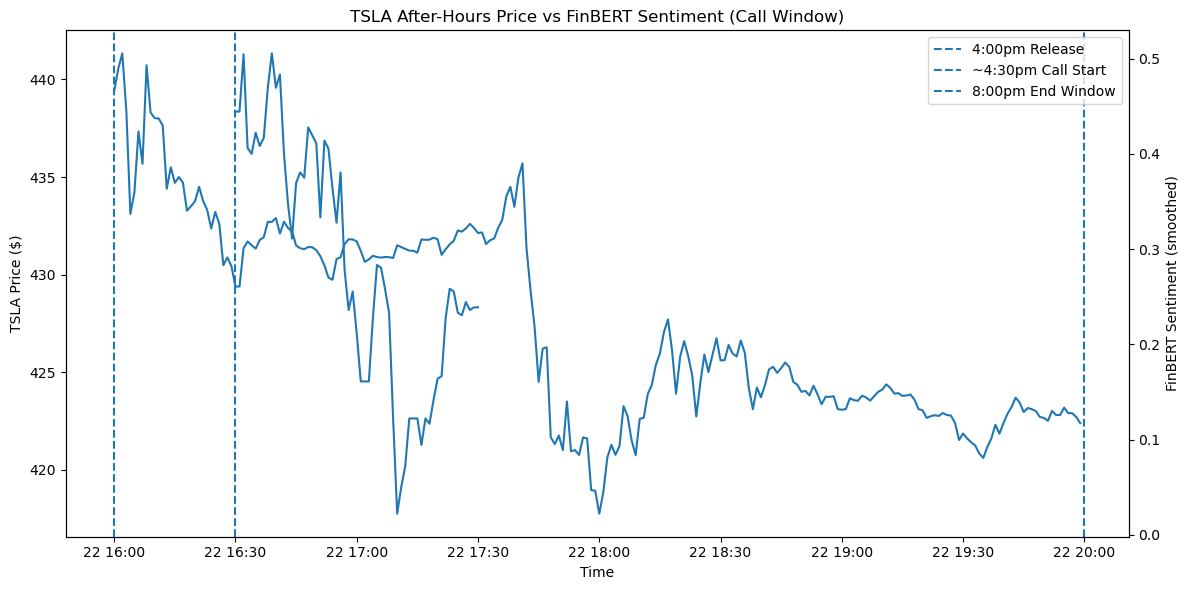

In [62]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Price (left axis)
ax1.plot(minute_df.index, minute_df["price"])
ax1.set_ylabel("TSLA Price ($)")
ax1.set_xlabel("Time")
ax1.set_title("TSLA After-Hours Price vs FinBERT Sentiment (Call Window)")

# Sentiment (right axis)
ax2 = ax1.twinx()
ax2.plot(minute_sent_smooth.index, minute_sent_smooth.values)
ax2.set_ylabel("FinBERT Sentiment (smoothed)")

# Mark key times
ax1.axvline(pd.Timestamp("2025-10-22 16:00:00"), linestyle="--", label="4:00pm Release")
ax1.axvline(call_start, linestyle="--", label="~4:30pm Call Start")
ax1.axvline(pd.Timestamp("2025-10-22 20:00:00"), linestyle="--", label="8:00pm End Window")

ax1.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [63]:
# Align sentiment & returns on same minutes
joint = pd.concat([minute_df["ret"], minute_sent_smooth], axis=1).dropna()
joint.columns = ["ret", "sent"]

corr = joint["ret"].corr(joint["sent"])

# quick OLS regression ret ~ sentiment
import statsmodels.api as sm
X = sm.add_constant(joint["sent"])
model = sm.OLS(joint["ret"], X).fit()

corr, model.summary()


(0.037052280660509994,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    ret   R-squared:                       0.001
 Model:                            OLS   Adj. R-squared:                 -0.016
 Method:                 Least Squares   F-statistic:                   0.08111
 Date:                Mon, 24 Nov 2025   Prob (F-statistic):              0.777
 Time:                        22:57:36   Log-Likelihood:                 330.88
 No. Observations:                  61   AIC:                            -657.8
 Df Residuals:                      59   BIC:                            -653.5
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------